# Project 3: Kaggle Competition - Semantic Segmentation


#### <font style="color:green">Maximum Points: 100</font>

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3><center>Sections</center></h3></td> <td><h3><center>Points</center></h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Custom Dataset Class</h3></td> <td><h3><center>7</center></h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Visualize Dataset</h3></td> <td><h3><center>3</center></h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Loss Function</h3></td> <td><h3><center>5</center></h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>Evaluation Metrics</h3></td> <td><h3><center>5</center></h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Model</h3></td> <td><h3><center>10</center></h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>Train and Plot Results</h3></td> <td><h3><center>7</center></h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>Inference</h3></td> <td><h3><center>3</center></h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>Prepare Submission CSV</h3></td><td><h3><center>10</center></h3></td> </tr>
        <tr><td><h3>9</h3></td> <td><h3>Kaggle Submission Score</h3></td> <td><h3><center>50</center></h3></td> </tr>
    </table>
</div>

**Kaggle Submission Score Points Distribution on Public Test Set**


<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Public Test Set Dice Score</h3></td> <td><h3><center>Points</center></h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3> <center>&le; 79%</center></h3></td><td><h3><center>0</center></h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3><center>80%</center></h3></td><td><h3><center>10</center></h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3><center>81%</center></h3></td><td><h3><center>20</center></h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3> <center>82%</center></h3></td><td><h3><center>30</center></h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3> <center>83%</center></h3></td><td><h3><center>40</center></h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3><center> &ge; 84%</center></h3></td><td><h3><center>50</center></h3></td> </tr>
    </table>
</div>

**Note: Percentages will be rounded off to the nearest integer.**

**<font style="color:red">Please do not make your notebooks public or publish them on the competition page. You only need to submit your notebook to the lab. This is to make sure that students don't copy each other. You are free to take references from any online resource.</font>**

----------

In [3]:
import os
import math
import random
import glob

from dataclasses import dataclass
import tensorflow as tf
import keras
from keras.utils import PyDataset
import tensorflow.keras.backend as K

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
from sklearn.model_selection import train_test_split

2025-11-04 03:37:59.780700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762227480.002776      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762227480.062406      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
## make sure that work is reproductitable
def set_seed():
    SEED_VALUE = 42
    
    tf.random.set_seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    random.seed(SEED_VALUE)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    
    # GPU
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
                
set_seed()

## 1. Custom Dataset Class [7 Points]

<font style="color:red">In this section you have to implement your own dataset generator.</font>

You can either the `Sequence` class or `tf.data` API or any other method to create training and validation data generators.

**Note:** There is no separate validation data, so you will have to create your own validation set by dividing training set into train and validation sets.


For example:

```python

class CustomSegmentationDataset(Sequence):
    
    def __init__(self, *, batch_size, image_size, image_paths, mask_paths, num_classes, apply_aug):
        '''
        Generic Dataset class for semantic segmentation datasets
        
        Arguments:
            batch_size:  Number of samples to be included in each batch of data.
            image_size:  Image and mask size to be used for training.
            image_paths: Path to image directory.
            mask_paths:  Path to masks directory.
            num_classes: Total number of classes present in dataset.
            apply_aug:   Should augmentations be applied.
        '''

```

In [5]:
colormap = np.array([(0,  0,    0),
                    (255, 0,    0), 
                    (200, 90,   90), 
                    (128, 128,  0), 
                    (155, 155,  155), 
                    (0,   255,  255), 
                    (55,  0,    255), 
                    (255, 0,    255), 
                    (245, 245,  0), 
                    (0,   255,  0)],  np.uint8)

In [6]:
class CustomSegementationDatatSet(PyDataset):
    def __init__(self, *, batch_size, image_size, image_paths, mask_paths, num_classes = 10, apply_aug = False, **kwargs):
        '''
        Generic Dataset class for semantic segmentation datasets
        
        Arguments:
            batch_size:  Number of samples to be included in each batch of data.
            image_size:  Image and mask size to be used for training.
            image_paths: Path to image directory.
            mask_paths:  Path to masks directory.
            num_classes: Total number of classes present in dataset.
            apply_aug:   Should augmentations be applied.
        '''
        super().__init__(**kwargs)
        self.batch_size = batch_size
        self.image_size = image_size
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.num_classes =  num_classes
        self.apply_aug = apply_aug
        self.original_size = image_size
        self.on_epoch_start()
        
    def __len__(self):
        # Return number of batches.
        return math.ceil(len(self.image_paths) / self.batch_size)

    def __getitem__(self, idx):
        # Return x, y for batch idx.
        low = idx * self.batch_size
        high = min(low + self.batch_size, len(self.mask_paths))
        batch_img = self.image_paths[low:high]
        batch_mask = self.mask_paths[low:high]

        batch_img, batch_mask, _ = self.transform(batch_img, batch_mask)
        return batch_img, batch_mask

    def transform(self, paths_img, paths_mask):

        imgs = np.zeros((self.batch_size,) + (self.image_size), dtype = np.float32)
        onehots = np.zeros((self.batch_size,) + (self.image_size[:2]) + (self.num_classes,), dtype = np.float32)
        H, W = self.image_size[:2]
        
        for j, (path_img, path_mask) in enumerate(zip(paths_img, paths_mask)):
            bimg = tf.io.read_file(path_img)
            bmask = tf.io.read_file(path_mask)
            img = tf.image.decode_jpeg(bimg, channels=self.image_size[2])
            mask = tf.image.decode_png(bmask, channels=self.image_size[2])
            self.original_size = img.numpy().shape
            
            preprocessing = A.Compose([
                A.HorizontalFlip(p=0.6) if self.apply_aug else A.NoOp(),
                A.VerticalFlip(p=0.6) if self.apply_aug else A.NoOp(),
                A.RandomScale(scale_limit=0.1, p=0.2) if self.apply_aug else A.NoOp(),
                A.Resize(height = H, width = W),
                A.Normalize(mean = 0.0, std = 1.0, max_pixel_value = 255.0)
            ])
    
            augmented = preprocessing(image=img.numpy(), mask=mask.numpy())
            img_rgb = augmented["image"]
            mask_rgb = augmented["mask"]

            # Initialisation du one-hot
            pixels_mask = mask_rgb.reshape(-1, 3)
            onehot = np.zeros((H * W, self.num_classes), dtype=np.float32)

            # Conversion du masque RGB en indices de classe
            for class_idx, color in enumerate(colormap):
                matches = np.all(pixels_mask == color, axis=-1)
                onehot[matches, class_idx] = 1.0

            imgs[j] = img_rgb.astype(np.float32)
            onehots[j] = onehot.reshape(H, W, self.num_classes).astype(np.float32)
            
        return imgs, onehots, self.original_size
        
    def on_epoch_start(self):
        combined = list(zip(self.image_paths, self.mask_paths))
        random.shuffle(combined)
        self.image_paths, self.mask_paths = zip(*combined)

In [7]:
@dataclass(frozen = True)
class DataConfig:
    ROOT_DIR : str = "/kaggle/input/open-cv-tf-project-3-image-segmentation-round-3/Project_3_FloodNet_Dataset"
    NUM_CLASSES: int = 10
    DATA_SHAPE: tuple = (256, 256, 3)

In [8]:
root_train_images = os.path.join(DataConfig.ROOT_DIR, "train/images")
root_train_masks = os.path.join(DataConfig.ROOT_DIR, "train/masks")
root_test = os.path.join(DataConfig.ROOT_DIR, "test/images")

paths_train_images = sorted(glob.glob(os.path.join(root_train_images, '*.jpg'),  recursive=True))
paths_train_masks = sorted(glob.glob(os.path.join(root_train_masks + '/*.png'),  recursive=True))
paths_test_image =  glob.glob(os.path.join(root_test + '/*.jpg'),  recursive=True)

print(f"Total images train: {len(paths_train_images)}")
print(f"Total images test: {len(paths_test_image)}")

Total images train: 1843
Total images test: 500


In [9]:
@dataclass(frozen = True)
class TrainingConfig:
    LEARNING_RATE: float = 0.0005
    NUM_EPOCH: int = 50
    NUM_BATCH: int = 16

    log_dir: str  = "/kaggle/working/logs"
    model_dir: str  = "/kaggle/working/model"

In [10]:
traintDataset = CustomSegementationDatatSet(batch_size = 32, 
                            image_size = DataConfig.DATA_SHAPE, 
                            image_paths = paths_train_images, 
                            mask_paths = paths_train_masks,
                            num_classes = DataConfig.NUM_CLASSES, 
                            apply_aug = True)

## 2. Visualize Dataset [3 Points]


<font style="color:red">In this section, you have to plot any 3 images from the training set with their corresponding masks and an overlayed image.</font>


For example:

---
---

<img src="https://learnopencv.com/wp-content/uploads/2022/06/c4-project3-GT.png">

---

In [11]:
def onehot_to_rgb(img, onehot_mask, colormap, original_size = (256, 256, 3)):

    if isinstance(onehot_mask, tf.Tensor):
        onehot_mask = onehot_mask.numpy()

    h, w = onehot_mask.shape[:2]
    mask_rgb = np.zeros((h, w, 3), dtype=np.uint8)

    # Appliquer la colormap
    for i, color in enumerate(colormap):
        mask = onehot_mask[:, :, i].astype(bool)
        mask_rgb[mask] = color

    #Back to original size
    h, w = original_size[:2]
    resize_image = A.Resize(height = h, width = w)(image=img, mask=mask_rgb)
    
    img_rgb = resize_image["image"]
    mask_rgb = resize_image["mask"]

    return img_rgb, mask_rgb

    
def showData(paths_img, paths_mask, rows = 5):
    cols = 3
    fig, ax = plt.subplots(nrows = rows, ncols = cols, figsize=(14, 8))
    fig.subplots_adjust(wspace=0.1, hspace=0.1)

    data = CustomSegementationDatatSet(batch_size = 1, 
                            image_size = DataConfig.DATA_SHAPE, 
                            image_paths = paths_img, 
                            mask_paths = paths_mask,
                            num_classes = DataConfig.NUM_CLASSES, 
                            apply_aug = True)

    for i in range(rows):
        # radomise per each iteration
        combined = list(zip(paths_img, paths_mask))
        random.shuffle(combined)
        paths_img, paths_mask = zip(*combined)
        batch_img, onehot_mask, size = data.transform(paths_img[:1], paths_mask[:1]) 
        
        image = (batch_img * 255).astype(np.uint8)
        image, mask = onehot_to_rgb(image[0], onehot_mask[0], colormap, size)
        
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask)
        ax[i, 2].imshow(image)
        ax[i, 2].imshow(mask, alpha=0.4)

        for j in range(cols):
            ax[i][j].axis('off')
            ax[i, j].set_aspect('auto')
    plt.show()


I0000 00:00:1762227497.157923      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762227497.158643      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


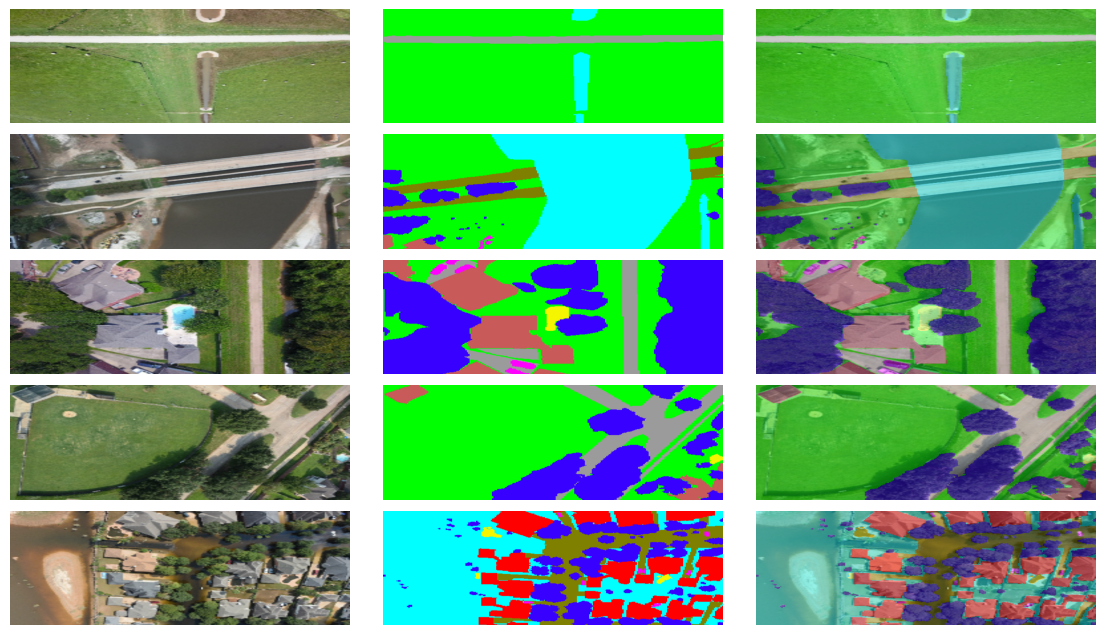

In [12]:
showData(paths_train_images, paths_train_masks)

## 3. Loss Function  [5 Points]

<font style="color:red">In this section, you have to implement the loss function you will be using for this dataset.</font>

1. The loss function can be `Cross-entropy`, `focal loss`, `IoU` or `Dice`.
2. You can also use a combination of the above mentioned functions.
3. You can also free to implement and use loss functions not taught in this course.

* Focal loss
$$ -\sum_{c=1}^{C} \alpha_c \cdot (1 - p_c)^{\gamma} \cdot y_c \cdot \log(p_c) $$
* Dice
$$ L_{\text{Dice}} = 1 - \frac{2 \sum_i p_i y_i + \epsilon}{\sum_i p_i + \sum_i y_i + \epsilon} $$

In [13]:
from keras.saving import register_keras_serializable

@register_keras_serializable()
def combined_focal_dice_loss(alpha=0.25, gamma=2, lambda1=1.0, lambda2=1.8):
    def loss(y_true, y_pred):
        # Clip pour éviter log(0)
        y_pred = K.clip(y_pred, K.epsilon(), 1.0)
        y_true = K.cast(y_true, 'float32')
        y_pred = K.cast(y_pred, 'float32')

        # Focal Loss
        focal = -alpha * K.pow(1 - y_pred, gamma) * y_true * K.log(y_pred)
        lfocal = K.mean(K.sum(focal, axis=-1))  # moyenne sur les classes

        # Dice Loss
        epsilon = K.epsilon()
        intersection = K.sum(y_true * y_pred, axis=[1,2,3])
        union = K.sum(y_true + y_pred, axis=[1,2,3])
        dice = 1 - (2. * intersection + epsilon) / (union + epsilon)
        ldice = K.mean(dice)

        # Combinaison pondérée
        return lambda1 * lfocal + lambda2 * ldice

    return loss

## 4. Evaluation Metrics [5 Points]

<font style="color:red">In this section, you have to implement the Dice coefficient evaluation metric.</font>

This competition is evaluated on the mean <a href="https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient" target="_blank">Dice coefficient</a>,  which helps compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by:


<p>$$DSC =  \frac{2 |X \cap Y|}{|X|+ |Y|}$$
$$ \small \mathrm{where}\ X = Predicted\ Set\ of\ Pixels,\ \ Y = Ground\ Truth $$ </p>
<p>The Dice coefficient is defined to be $1$ when both $X$ and $Y$ are empty.</p>



In [14]:
def dice_metric(y_true, y_pred):
    epsilon = K.epsilon()
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    intersection =  K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true + y_pred, axis=[1, 2, 3])
    dice = (2. * intersection + epsilon) / (union + epsilon)
    
    return K.mean(dice)

## 5. Model [10 Points]

<font style="color:red">In this section you have to define your segmentation model.</font>

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

# Bloc convolutif double
def conv_double_block(x, filters, dropout_rate=None):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    if dropout_rate > 1:
        x = layers.SpatialDropout2D(dropout_rate)(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    return x


def u_net_model(input_shape=(256, 256, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = conv_double_block(inputs, 32, dropout_rate=0.4)
    pool1 = layers.MaxPooling2D(pool_size=2)(conv1)
    #pool1 = layers.SpatialDropout2D(0.4)(pool1)

    conv2 = conv_double_block(pool1, 64, dropout_rate=0.4)
    pool2 = layers.MaxPooling2D(pool_size=2)(conv2)
    #pool2 = layers.SpatialDropout2D(0.4)(pool2)

    conv3 = conv_double_block(pool2, 128, dropout_rate=0.4)
    pool3 = layers.MaxPooling2D(pool_size=2)(conv3)
    #pool3 = layers.SpatialDropout2D(0.4)(pool3)

    conv4 = conv_double_block(pool3, 256, dropout_rate=0.4)
    pool4 = layers.MaxPooling2D(pool_size=2)(conv4)
    #pool4 = layers.SpatialDropout2D(0.4)(pool4)

    # Bottleneck
    bottleneck = conv_double_block(pool4, 512, dropout_rate=0.4)
    #bottleneck = layers.SpatialDropout2D(0.2)(bottleneck)

    # Decoder
    up1 = layers.Conv2DTranspose(256, kernel_size=2, strides=2, padding='same')(bottleneck)
    concat1 = layers.Concatenate()([up1, conv4])
    conv5 = conv_double_block(concat1, 256, dropout_rate=0.4)

    up2 = layers.Conv2DTranspose(128, kernel_size=2, strides=2, padding='same')(conv5)
    concat2 = layers.Concatenate()([up2, conv3])
    conv6 = conv_double_block(concat2, 128, dropout_rate=0.4)

    up3 = layers.Conv2DTranspose(64, kernel_size=2, strides=2, padding='same')(conv6)
    concat3 = layers.Concatenate()([up3, conv2])
    conv7 = conv_double_block(concat3, 64, dropout_rate=0.4)

    up4 = layers.Conv2DTranspose(32, kernel_size=2, strides=2, padding='same')(conv7)
    concat4 = layers.Concatenate()([up4, conv1])
    conv8 = conv_double_block(concat4, 32, dropout_rate=0.4)

    # Output
    outputs = layers.Conv2D(num_classes, kernel_size=1, activation='softmax')(conv8)

    model = models.Model(inputs, outputs)
    return model


In [16]:
model = u_net_model(DataConfig.DATA_SHAPE, DataConfig.NUM_CLASSES)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[

 Total params: 7,772,170 (29.65 MB)

 Trainable params: 7,766,282 (29.63 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import os
import datetime

def get_callbacks(save_model_only = True, save_weights_only = False):
    # Dossier de logs pour TensorBoard
    log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_cb = TensorBoard(log_dir=log_dir)

    # EarlyStopping
    earlystop_cb = EarlyStopping(
        monitor='val_loss',
        patience=6,
        restore_best_weights=True,
        verbose=1
    )

    checkpoint_filepath = os.path.join("model", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    # Update file path if saving best model weights.
    if save_weights_only:
        checkpoint_filepath = os.path.join(checkpoint_filepath, "model.ckpt")
    else:
        checkpoint_filepath = os.path.join(checkpoint_filepath, "model.keras")
        
    # Sauvegarde des poids uniquement
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        save_best_only = save_model_only,
        save_weights_only = save_weights_only,
        verbose=0
    )

    # Réduction du learning rate en cas de plateau
    reduce_lr_cb = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1,
        min_lr=1e-7,
    )

    return [tensorboard_cb, earlystop_cb, checkpoint, reduce_lr_cb]

## 6. Train and Plot Results [7 Points]

<font style="color:red">In this section you have to:</font>
    
1. Implement the training pipeline.

2. Train the model.

3. Plot loss and metrics for training and validation set.


In [18]:
def get_data(path_images, 
             path_masks, 
             trainingConfig=TrainingConfig, 
             dataConfig=DataConfig):
    
    df = pd.DataFrame({
        "images": path_images,
        "masks": path_masks
    })

    train_df, val_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

    # Dataset d'entraînement
    train_dataset = CustomSegementationDatatSet(
        batch_size=trainingConfig.NUM_BATCH,
        image_size=dataConfig.DATA_SHAPE,
        image_paths=train_df["images"].tolist(),
        mask_paths=train_df["masks"].tolist(),
        num_classes=dataConfig.NUM_CLASSES,
        apply_aug=True  
    )

    # Dataset de validation
    val_dataset = CustomSegementationDatatSet(
        batch_size=trainingConfig.NUM_BATCH,
        image_size=dataConfig.DATA_SHAPE,
        image_paths=val_df["images"].tolist(),
        mask_paths=val_df["masks"].tolist(),
        num_classes=dataConfig.NUM_CLASSES,
        apply_aug=False
    )

    return train_dataset, val_dataset, (train_df, val_df)


In [19]:
train_dataset, val_dataset, data_frame = get_data(paths_train_images, 
             paths_train_masks, 
             trainingConfig=TrainingConfig, 
             dataConfig=DataConfig)


In [20]:
from tensorflow.keras.optimizers import Adam

# Compilation du modèle
model.compile(
    optimizer=Adam(learning_rate=TrainingConfig.LEARNING_RATE),
    loss=combined_focal_dice_loss(),
    metrics=[dice_metric]  # 'accuracy' n'est pas une fonction ici, tu veux probablement ton dice_metric
) 

In [21]:
callbacks = get_callbacks()

history = model.fit(
    train_dataset,
    epochs=TrainingConfig.NUM_EPOCH,
    batch_size=TrainingConfig.NUM_BATCH,
    validation_data=val_dataset,  
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50


I0000 00:00:1762227520.265693     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


93/93 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - dice_metric: 0.4149 - loss: 1.4454 - val_dice_metric: 0.0976 - val_loss: 3.5780 - learning_rate: 5.0000e-04
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - dice_metric: 0.6261 - loss: 0.9452 - val_dice_metric: 0.0960 - val_loss: 4.2456 - learning_rate: 5.0000e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - dice_metric: 0.6960 - loss: 0.7767 - val_dice_metric: 0.0934 - val_loss: 3.5429 - learning_rate: 5.0000e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - dice_metric: 0.7240 - loss: 0.6918 - val_dice_metric: 0.2209 - val_loss: 3.2107 - learning_rate: 5.0000e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - dice_metric: 0.7311 - loss: 0.6771 - val_dice_metric: 0.4052 - val_loss: 2.0391 - learning_rate: 5.0000e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - dice_metric: 0.7483 - loss: 0.6373 - val_dice_metric: 0.6569 - val_loss: 0.9730 - learning_rate: 5.0000e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 110s 1s

In [22]:
def plot_metric(history):
    metrics = list(history.history.keys())
    values = list(history.history.values())
    for i  in range(3):
        plt.figure(figsize=(12, 6))
        if(i < 2):
            plt.plot(values[i], label = metrics[i])
            plt.plot(values[i+2], label = metrics[i+2])
            plt.title(f'Train and Validation {metrics[i]}')
        else:
            plt.plot(values[-1], label = metrics[-1])
            plt.title(f'Learning Rate')
        plt.xlabel('Epoch')
        plt.legend()
        plt.grid(True)
        plt.show()
    

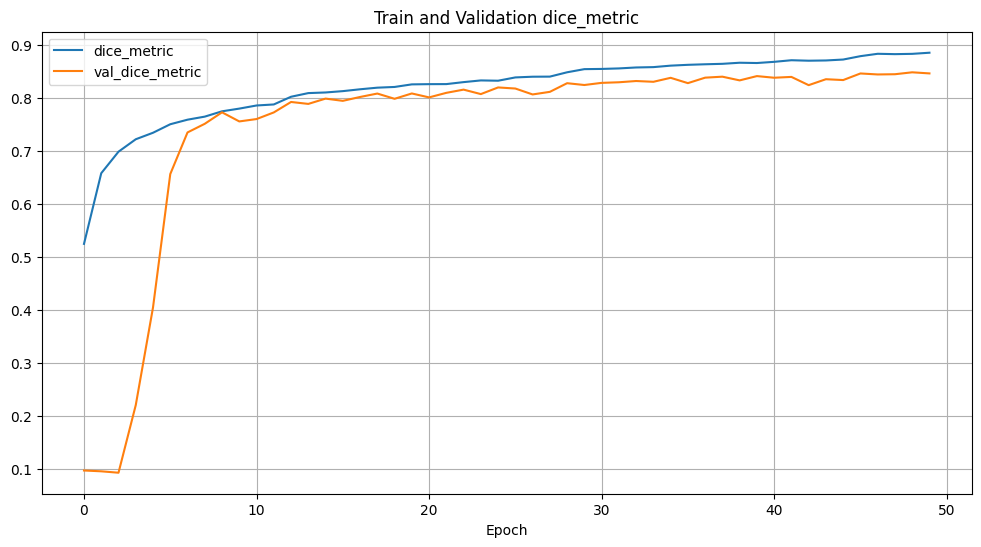

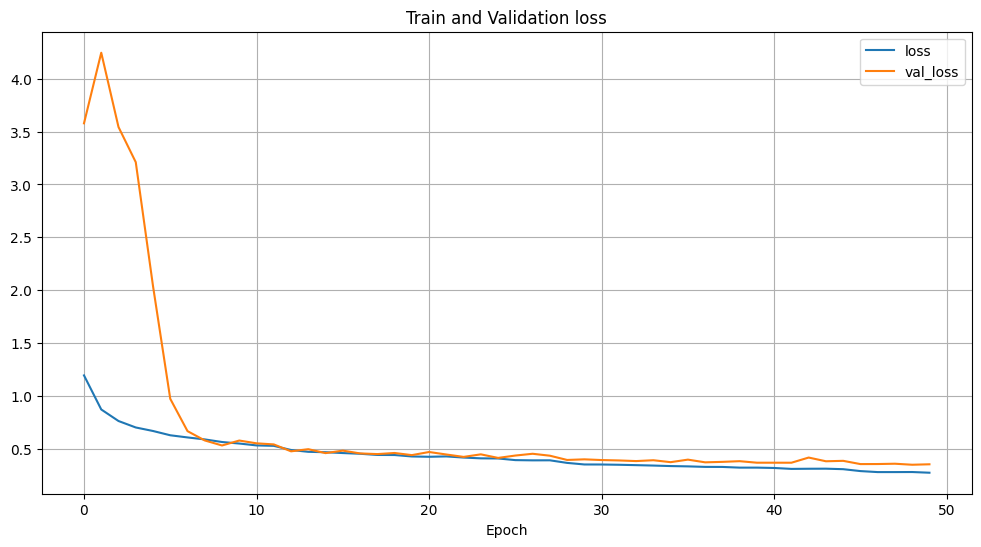

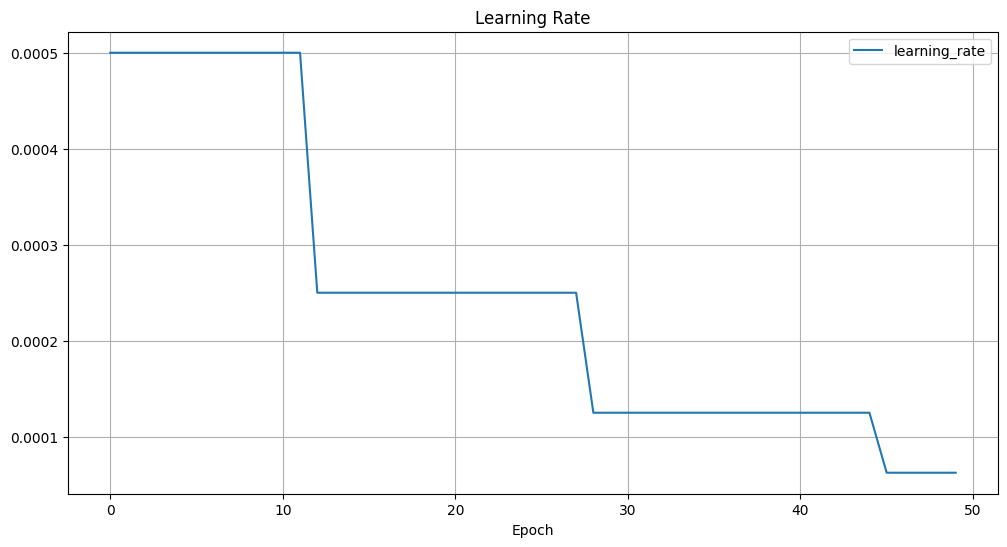

In [23]:
plot_metric(history)

## 7. Inference [3 Points]


<font style="color:red">Plot inferences on 3 random images from your validation set.</font>

<font style="color:green">Note: Inference should be performed on the original image size and not on any resized image.</font>

**E.g., if the original image has (H, W) of (512, 384) and your model returns a final output (H', W') shape of (256, 256).
You need to resize your outputs to size (512, 384) before plotting.**


Example plots:

---
---

<img src='https://learnopencv.com/wp-content/uploads/2022/06/c4-project3-Preds.png'>


---


In [24]:
import os
from tensorflow import keras

def get_load_model(save_model_only =True, save_weights_only = False, ):
    model_files = os.listdir(TrainingConfig.model_dir)
    
    model_files = sorted(model_files)
    
    path_save_model = os.path.join(TrainingConfig.model_dir, model_files[-1])
    if save_weights_only:
        path_save_model = os.path.join(path_save_model, "model.ckpt")
    else:
        path_save_model = os.path.join(path_save_model, "model.keras")
    print(path_save_model)
    
    # Charge le modèle
    train_model = model = keras.models.load_model(path_save_model, compile=True,
    custom_objects={
        'loss': combined_focal_dice_loss(), 
        'dice_metric': dice_metric
    }
)
    return train_model

In [25]:
train_model = get_load_model()

/kaggle/working/model/20251104-033820/model.keras


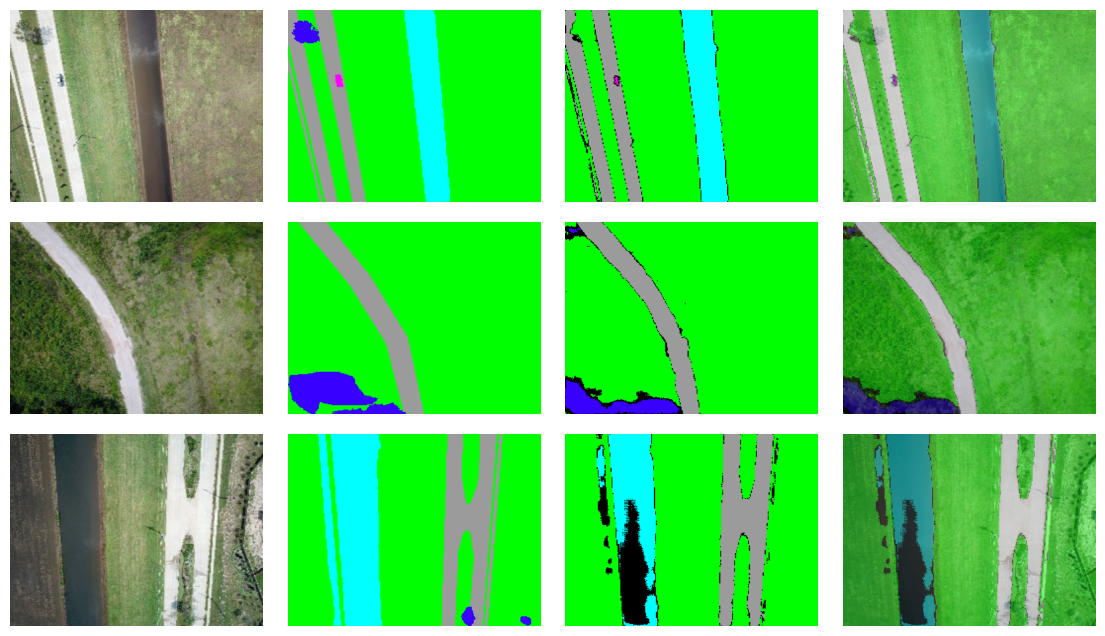

In [54]:
cols = 4
rows = 3
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(14, 8))
fig.subplots_adjust(wspace=0.1, hspace=0.1)

data = CustomSegementationDatatSet(batch_size = 1, 
                        image_size = DataConfig.DATA_SHAPE, 
                        image_paths = paths_train_images,  
                        mask_paths = paths_train_masks,
                        num_classes = DataConfig.NUM_CLASSES, 
                        apply_aug = True)

for i in range(rows):
    index = np.random.randint(len(data_frame[1]))
    path_img, path_mask = data_frame[1].iloc[index]
    img, onehot_mask, size = data.transform([path_img], [path_mask])
    predict_mask = train_model(img)
    predict_mask = tf.squeeze(predict_mask).numpy()
    img = tf.squeeze(img).numpy()
    binary_mask = (predict_mask >= 0.70).astype(np.float32)
 
    img = (img * 255).astype(np.uint8)
    image, predict_mask = onehot_to_rgb(img, binary_mask, colormap, size)
    image, mask = onehot_to_rgb(img, onehot_mask[0], colormap, size)

    ax[i, 0].imshow(image)
    ax[i, 1].imshow(mask)
    ax[i, 2].imshow(predict_mask)
    ax[i, 3].imshow(image)
    ax[i, 3].imshow(predict_mask, alpha=0.4)

    for j in range(cols):
        ax[i, j].axis('off')
        ax[i, j].set_aspect('auto')

plt.show()

## 8. Prepare Submission CSV [10 Points]


<font style="color:red">Write your code to prepare the submission CSV file.</font>

**Note:** In the submission file, you have to write pixel values in ***Run-length Encoded format***. This is done to reduce the size of submission file.

**A note on how Run-length encoding for Kaggle competitions** (taken from [HuBMAP - Hacking the Kidney Competition](https://www.kaggle.com/code/leahscherschel/run-length-encoding/notebook))

> *To reduce the submission file size, teams must submit segmentation results using run-length encoding on the pixel values. Instead of submitting an exhaustive list of indices for your segmentation, you will submit pairs of values that contain a start position and a run length. E.g. `0 3` implies starting at `pixel 0` and running a total of `3` pixels `(0,1,2)`. The competition format requires a space-delimited list of pairs. For example, `0 3 10 5` implies pixels `0,1,2`, and `10,11,12,13,14` are to be included in the mask. The metric checks that the pairs are sorted and positive and the decoded pixel values are not duplicated. The pixels are numbered from **top to bottom, then left to right:** 0 is pixel (0,0), 1 is pixel (1,0), and 2 is pixel (2,0), etc.*

---

Additional RLE code discussion from the same competition: [Fast Code to Convert Mask to RLE](https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/232357)

[Here another blog post to understand what is Encoded Pixels.](https://medium.com/analytics-vidhya/generating-masks-from-encoded-pixels-semantic-segmentation-18635e834ad0)

**You are free to use any code available online as long as the output format is maintained.**  

----

1. For generating a `submission.csv` file, you need to encode the model outputs for images in the testing set using **Run-Length Encoding (RLE)**.

2. RLE is performed on binary masks. So RLE is performed on each output channel.

3. RLE needs to performed on predictions outputs having the same size as the original image

4. Similar to **Inference section**, if the original image has (H, W) of (512, 384) and your model returns a final output (H', W') shape of (256, 256). You need to resize your outputs to size (512, 384) before performing RLE.


**Required Columns:**
1. **`IMG_ID`**
2. **`EncodedString`**

----



In [59]:
from skimage.transform import resize

def rle_encode(img):
    '''
    Efficient implementation of mask2rle, from @paulorzp
    --
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    Source: https://www.kaggle.com/xhlulu/efficient-mask2rle
    '''
    pixels = img.T.flatten()
    pixels = np.pad(pixels, ((1, 1), ))
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def preprocess_image(path, image_size):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    original_size = tf.shape(img)[:2]
    img = tf.image.resize(img, image_size)
    img = tf.cast(img, tf.float32) / 255.0
    return img, original_size

def create_test_dataset(paths, image_size=(256, 256), batch_size=16):
    ds = tf.data.Dataset.from_tensor_slices(paths)
    ds = ds.map(lambda x: preprocess_image(x, image_size), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

def resize_mask(mask, target_shape):
    return resize(mask, target_shape, order=0, preserve_range=True, anti_aliasing=False).astype(np.uint8)


In [60]:
def generate_submission_rle_batch(root_test_file, model,
                                image_size=(256, 256),  sample_csv='sample_submission.csv',
                                output_csv='submission.csv',threshold=0.75
):

    sample_df = pd.read_csv(sample_csv)
    expected_ids = sample_df['IMG_ID'].tolist()
    image_names = sorted(set([img_id.split('_')[0] for img_id in expected_ids]))
    paths_test_image = [os.path.join(root_test_file, f"{name}.jpg") for name in image_names]
    test_ds = create_test_dataset(paths_test_image, image_size=image_size, batch_size=8)

    all_preds = []
    all_original_sizes = []

    # Prédictions by batch
    for batch_images, batch_sizes in test_ds:
        preds = model.predict(batch_images, verbose=0)
        all_preds.append(preds)
        all_original_sizes.extend(batch_sizes.numpy())

    predictions = np.concatenate(all_preds, axis=0)
    original_sizes = np.array(all_original_sizes)

    # --- Generate the encodes mask ---
    rle_dict = {}

    for i, img_path in enumerate(paths_test_image):
        img_id_base = os.path.splitext(os.path.basename(img_path))[0]
        orig_h, orig_w = original_sizes[i]
        pred = predictions[i]  # shape: (H', W', C)

        for class_id in range(pred.shape[-1]):
            mask = pred[..., class_id]
            binary_mask = (mask > threshold).astype(np.uint8)  
            resized_mask = resize_mask(binary_mask, (orig_h, orig_w))
            rle = rle_encode(resized_mask)
            key = f'{img_id_base}_{class_id:02d}'
            rle_dict[key] = rle

    # --- Create final CSV ---
    final_rows = [{'IMG_ID': img_id, 'EncodedString': rle_dict.get(img_id, "")} for img_id in expected_ids]
    print("Chemin absolu du fichier :", os.path.abspath(output_csv))
    print("Nombre de lignes générées :", len(final_rows))
    print("Exemple de ligne :", final_rows[0] if final_rows else "Aucune donnée")

    pd.DataFrame(final_rows).to_csv(output_csv, index=False)
    print(f"✅ Submited file was génerated : {output_csv}")

In [61]:
sampe_submission = '/kaggle/input/open-cv-tf-project-3-image-segmentation-round-3/sample_submission.csv'
root_test_file = "/kaggle/input/open-cv-tf-project-3-image-segmentation-round-3/Project_3_FloodNet_Dataset/test/images"
generate_submission_rle_batch(root_test_file, model, image_size=(256, 256), sample_csv=sampe_submission, output_csv='/kaggle/working/submission.csv')

2025-11-04 05:37:59.467022: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-11-04 05:38:04.584274: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Chemin absolu du fichier : /kaggle/working/submission.csv
Nombre de lignes générées : 5000
Exemple de ligne : {'IMG_ID': '10181_00', 'EncodedString': ''}
✅ Submited file was génerated : /kaggle/working/submission.csv


In [58]:
! rm submission.csv

As RLE works on one binary mask at a time and we have multiple classes per image. Each image should have `10`  rows in your `submission.csv` file.

Example: For Image name = `test_image.jpg`


**IMG_IDs** will be

```python
test_image_00
test_image_01
test_image_02
test_image_03
test_image_04
test_image_05
test_image_06
test_image_07
test_image_08
test_image_09
```

**Format:** `{image_name}_{class_id}` (no extention)

----

**`sample_submission.csv`.**

```html
IMG_ID,EncodedString
10181_00,
10181_01,
10181_02,
10181_03,
10181_04,
10181_05,227 2 707 2 1187 2 1667 2
10181_06,28317 4 28797 4 29277 4 29757 4 35035 6 35515 6 35995 6 36475 6 36955 6 37435 6 37917 4 38397 4
10181_07,
10181_08,
10181_09,
10806_00,
10806_01,
10806_02,140621 4 141101 4
10806_03,
10806_04,3143 12 3159 6 3623 12 3639 6 4025 14 409
```


**`EncodedString`** can be blank if there's no prediction available.

----

## 9. Kaggle Submission Score [50 Points]

You need a minimum dice score of `80%` on the **Public test leaderboard**.<br>

If the Dice score is less than `80%`, you gain no points for this section.

**Dice scores will be rounded-off to the nearest integer.**

Submit `submission.csv` (prediction for images in test.csv) in the **Submit Predictions** tab in Kaggle to get evaluated for this section.

Please share your profile link, user id and score achieved.

```
URL:
Profile Name:
Points Scored:
```


**Upon completing the project, <font style="color:red">upload the notebook to the lab for grading and feedback.</font>**